# <center> Seaflow Change-Point Estimation Example on KOK1606</center>

This notebook demonstrates how to estimate change points in both the biological data and physical data on the KOK1606 cruise.

## 1. Loading and Cleaning the Data
First we'll load the data. As noted in the paper, there is biological data consisting of measurements of light scatter and fluorescence (chlorophyll and phycoerythrin) of individual phytoplanton particles. There is also physical data consisting of temperature and salinity measurements of the ocean along the cruise track.

The biological data is organized into point clouds recorded every 3 minutes, where each point in a point cloud is resolved to $2^{16}$ discrete values. The light intensity measured by a photomultiplier tube was converted via a pre-amplifier to a voltage that was then input into a logarithmic amplifier. The data we begin with is the output from the logarithmic amplifier, after a cleaning step metnioned next.

In the code block below you may need to provide the path to the directory containing the biological and physical data. 

In [1]:
import os
import pandas as pd

data_dir = '../data/' 
cruise = 'SCOPE_16'  # Another name for KOK1606

bio_data = pd.read_parquet(os.path.join(data_dir, cruise + '_bio.parquet'))
phys_data = pd.read_parquet(os.path.join(data_dir, cruise + '_phys.parquet'))

The data has been pre-cleaned to remove anomalous temperature and salinity data (salinities outside of [29, 38] PSU and temperatures outside of [5, 30] C), to remove measurements of beads, and to remove times for which there does not exist both biological and physical data.

Both the physical data and biological data are returned as pandas dataframes. We can check that the start and end dates are the same for both sets of data.

In [2]:
phys_data.head()

,date,latitude,longitude,temp,salinity
0,2016-04-20T00:04:37+00:00,21.4542,-158.3111,25.8146,34.6926
1,2016-04-20T00:07:37+00:00,21.4614,-158.3132,25.8207,34.6917
2,2016-04-20T00:10:37+00:00,21.4688,-158.3151,25.8019,34.6895
3,2016-04-20T00:13:37+00:00,21.4760,-158.3171,25.8028,34.6863
4,2016-04-20T00:16:37+00:00,21.4833,-158.3193,25.7732,34.6829


In [3]:
bio_data.head()

,date,fsc_small,chl_small,pe,pop
0,2016-04-20T00:04:37+00:00,5.441489,6.373004,2.250701,prochloro
1,2016-04-20T00:04:37+00:00,8.290469,11.056101,1.715528,prochloro
2,2016-04-20T00:04:37+00:00,26.782829,34.841061,1.926695,unknown
3,2016-04-20T00:04:37+00:00,12.556741,33.782091,2.531164,prochloro
4,2016-04-20T00:04:37+00:00,8.522009,9.552181,2.990096,prochloro


In [4]:
phys_data.tail()

,date,latitude,longitude,temp,salinity
6680,2016-05-04T02:18:43+00:00,22.9415,-157.9985,24.5491,35.0384
6681,2016-05-04T02:21:44+00:00,22.9343,-157.9985,24.5144,35.0541
6682,2016-05-04T02:24:44+00:00,22.9272,-157.9987,24.4773,35.0663
6683,2016-05-04T02:27:44+00:00,22.9200,-157.9987,24.4808,35.0671
6684,2016-05-04T02:30:45+00:00,22.9128,-157.9988,24.5078,35.0586


In [5]:
bio_data.tail()

,date,fsc_small,chl_small,pe,pop
2288487,2016-05-04T02:30:45+00:00,17.067807,35.814118,1.861026,prochloro
2288488,2016-05-04T02:30:45+00:00,4.090877,11.209428,2.378174,prochloro
2288489,2016-05-04T02:30:45+00:00,1.998855,10.622950,3.331825,unknown
2288490,2016-05-04T02:30:45+00:00,5.089382,7.106597,2.670906,prochloro
2288491,2016-05-04T02:30:45+00:00,9.165543,4.446027,1.482171,prochloro


There are 6,685 point clouds (due to zero-based indexing) and 2.3 million total particle measurements.

Examining the latitude and longitude of the cruise, we can see that the cruise took place near Hawaii. The locations from the beginning of the cruise are in red and the the colors of the locations progressively move toward violet.

<Figure size 432x288 with 0 Axes>

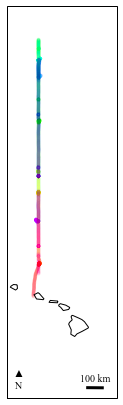

In [6]:
import sys
sys.path.append('..')
from figures import figures
%matplotlib inline

extent = [-160, -153, 15, 40]
figures.cruise_path_plot(phys_data[['latitude']], phys_data[['longitude']], extent=extent, colors='rainbow', 
                    figure_size=(9.6, 7.2), save_path=None)

## 2. Generating Features
From the dataframes we just obtained we'll generate features for the physical and biological data that we will use for change-point detection.

### 2.1 Features for the physical data
First consider the physical data. In order to treat the temperature and salinity data equally we'll standardize the data:

In [7]:
import numpy as np

phys_features = np.asarray(phys_data[['salinity','temp']])
phys_features = (phys_features-np.mean(phys_features, axis=0))/np.std(phys_features, axis=0)

### 2.2 Features for the biological data
Next consider the biological data. We will first log-transform and then standardize the data. 

In [8]:
bio_array = np.log10(np.asarray(bio_data[['fsc_small', 'chl_small', 'pe']]))
bio_array = (bio_array-np.mean(bio_array, axis=0))/np.std(bio_array, axis=0)

Now recall that there are thousands of measurements for each time point (3-minute window). We will refer to such a set of measurements as a "point cloud". Each point cloud can be viewed as an empirical distribution. The goal of this work is to locate changes in the distributions of the biological properties of the particles over time (i.e., along the path of the cruise). 

In order to locate changes in the distributions we will avoid explicitly estimating the corresponding densities. We can do so by mapping the point clouds into a Reproducing Kernel Hilbert Space $\mathcal{H}$ (Smola et al., 2007). The general idea is that we can map each point in the point cloud into $\mathcal{H}$, and then summarize the data by the mean $\hat\mu_t$ of those embeddings at each time $t$. For certain mappings the mapping from a distribution $P_t$ to its corresponding mean in the Hilbert space, $\mu_{t}$, is injective. Therefore, we can search for changes in distribution by searching for changes in the means $\mu_{t}$. As we only have approximations $\hat\mu_t$ of $\mu_{t}$, we will instead search for changes in $\hat\mu_t$.

One potential problem with the above method is that each $\hat\mu_t$ is infinite-dimensional. However, our algorithm only relies on inner products between the embedding of each point, so we don't actually need to compute each $\hat\mu_t$. On the other hand, computing millions of inner products (one for every pair in the 2.3 million initial particle measurements) is infeasible. Therefore, we will generate features that can approximate the inner products. We do so by projecting onto a subspace using the Nyström method (Williams and Seeger, 2000). We select the landmarks in the Nyström method by running $k$-means and using the resultant cluster centroids.

All of this can be done with our package Chapydette, so it is only necessary to understand the required inputs. The required inputs are:
- data_features: Data that features will be generated for. Each particle corresponds to one row.
- nclusters: Desired dimension of the approximation. 128 seems to work well.

The most noteworthy optional inputs with their defaults in parentheses are:
- window_length: For some applications there might not be a sufficient amount of points per time point. In this case one can use a sliding window over time. The window_length parameter is the length of such a sliding window. This is terms of time if you input a vector for `times` (see below) or in terms of indices otherwise. 
- window_overlap (0.2*window_length): When you use the sliding window method, you may want the sliding windows to overlap. The window_overlap parameter is how much they should overlap, in terms of time.  
- times (None): Times corresponding to each data point. If you want the sliding windows to be based on time rather than index, you need to specify a vector of times, with one time for each row in the dataset. For example, you can input an integer file number (corresponding to each 3-minute window) for each row.
- bandwidth (None): Bandwidth of the RBF kernel that the features will be used to approximate.  If None it uses the median pairwise distance rule of thumb to set the bandwidth.
- standardize (True): Whether to standardize the inputs.
- do_pca (True): Whether to perform PCA on the data.
- kmeans_iters (100): Number of iterations of k-means to perform.
- seed (None): The seed used in random number generation (so that the results are reproducible).

For this example, we'll use the following:
- data_features = the biological data we loaded above
- nclusters = 128. We have found that 128 seems to work well.
- window_length = 1. We analyze all of the data in one 3-minute window at a time.
- window_overlap = 0. We analyze each 3-minute time window separately.
- times = a time index corresponding to each 3-minute window.
- bandwidth = None. We'll use the rule of thumb.
- standardize = False. We already standardized the data.
- do_pca = False. We only have 3 variables, so we don't need to run PCA.
- kmeans_iters = 100. We have found 100 to be effective, but you could try increasing it. If this step is too slow you can also try decreasing it, but that may impact the performance.
- seed = 0.

The output of the feature generation step consists of several things:
- features: The features that you should input into the change-point estimation algorithm
- interval_start_times: Start time of every sliding window  
- interval_end_times: End time of every sliding window
- scaler: The Scikit-learn scaler used to standardize the data (if applicable)
- pca: The trained PCA function (if applicable)
- centroids: The centroids from the $k$-means step
- bandwidth: The bandwidth that was used 

Only the first output will be relevant to us now. The last four could be useful if you are processing data in batches and need to be able to generate features in the same way later.

In [9]:
from chapydette import feature_generation

nclusters = 128
window_length = 1
window_overlap = 0
times = np.array(pd.Series(bio_data['date']).astype('category').cat.codes.values + 1)
bandwidth = None
standardize = False
do_pca = False
kmeans_iters = 100
seed = 0

bio_features = feature_generation.nystroem_features(bio_array, nclusters, window_length=window_length, 
                                                    window_overlap=window_overlap, times=times, 
                                                    bandwidth=bandwidth, standardize=standardize, 
                                                    do_pca=do_pca, kmeans_iters=kmeans_iters, seed=seed)[0]

Running k-means...
Using rule of thumb bandwidth: 1.9036617511666836
Generating features...
100.00 % done
Done generating features.


To summarize, we did the following:
1. Selected 128 landmarks for the Nyström method to approximate an RBF kernel by running $k$-means on all 2.3 million particle measurements with $k=128$. 
2. Projected every point within each point cloud onto the resultant 128-dimensional space. The inner product of any two of these approximates the evaluation of an RBF kernel with the rule-of-thumb bandwidth on the pair of points.
3. Averaged the projections within each point cloud to obtain one 128-dimensional vector per point cloud.

Therefore, at this point we have one 128-dimensional vector for each point cloud:

In [10]:
bio_features.shape

(6685, 128)

## 3. Change-Point Estimation with a Fixed Number of Change Points
Now that we've generated features, we can run the change-point estimation algorithm. In this section we'll fix the number of change points. In the next section we will estimate the number of change points.

Chapydette currently contains implementations of two different kernel-based change-point algorithms. The relevant algorithm here is an implementation of the multiple kernel change-point estimation algorithm of Harchaoui and Cappé (2007). 

The main inputs with their defaults in parentheses are:
- X (None): Matrix of features. Each observation corresponds to one row.
- gram (None): Pre-computed Gram matrix.
- n_cp (1): Number of change points to detect. This can also be a tuple indicating a range, e.g., (0, 150)
- kernel_type ('detect'): Type of kernel to use. For the biological data we'll use the Gaussian RBF kernel ('gaussian-euclidean'). For the physical data we will use the linear kernel ('linear').
- bw (None): Bandwidth for the kernel (if applicable). If None and if applicable, it uses a rule of thumb.
- min_dist (1): Minimum allowable distance between successive change points.

You must provide either X or gram. If you do not specify kernel_type, the code will try to determine an appropriate kernel to use. If you do not provide a bandwidth and a bandwidth is required, the code will use a rule of thumb for the bandwidth. 

The outputs of the algorithms are the estimated change points, in terms of the indices of the observations. The estimated change points are the indices of the **last observation** in each estimated segment.

### 3.1 Change-point estimation on the physical data
We'll start by performing change-point estimation on the physical data. We'll look for 10 change points and require that each change point must be at least 5 observations (i.e., ~15 minutes) apart. For the physical data we use the linear kernel because we want to detect changes in the mean of the observations in $\mathbb{R}^2$.

In [11]:
from chapydette import cp_estimation

cps_phys = cp_estimation.mkcpe(X=phys_features, n_cp=10, kernel_type='linear', bw=None, min_dist=5)

print('Estimated physical change points (in terms of time indices):\n', cps_phys.flatten())

Estimated physical change points (in terms of time indices):
 [ 270 1079 2122 2553 2955 3973 4957 5258 5418 6339]


The output change points are the indices of the last observation within each segment. In other words, if the output was [ 270 1073 2111 2542 2943 3961 4945 5246 5406 6221] this means the algorithm segmented the data into observations 0-270, 271-1073, 1074-2111, etc. We'll visualize the results in a minute, but let's first perform the change-point detection on the biological data.

### 3.2 Change-point estimation on the biological data

Now we'll perform change-point estimation on the biological data. We will again look for 10 change points and require that each change point must be at least 5 observations (i.e., ~15 minutes) apart. We will use the Gaussian kernel with the Euclidean distance.

In [12]:
cps_bio = cp_estimation.mkcpe(X=bio_features, n_cp=10, kernel_type='gaussian-euclidean', bw=None, min_dist=5)

print('Estimated biological change points (in terms of time indices):\n', cps_bio.flatten())

Bandwidth not specified. Using a rule of thumb.
Estimated biological change points (in terms of time indices):
 [ 867 1970 2133 2573 3040 3975 4261 4959 5420 6320]


We can see that six of the estimated biological change points are within 20 indices of the estimated physical change points. 

### 3.3 Figures
Let's take a look to see if the above results are reasonable.

In [13]:
import matplotlib.pyplot as plt

def temp_salinity_plot(cps_bio, cps_phys):
    plt.clf()
    fig, ax1 = plt.subplots(figsize=(9.6, 7.2))

    # Plot the temperature and salinity data
    temp_color = plt.get_cmap('Set3').colors[3]
    ax1.plot(dists, phys_data['temp'], color=temp_color, alpha=0.5)
    ax1.set_xlabel('Alongtrack distance (km)', fontsize=20)
    ax1.set_ylabel('Temperature ($^\circ$C)', color=temp_color, fontsize=20, alpha=0.5)
    ax1.tick_params('y', colors=temp_color, grid_alpha=0.5)

    ax2 = ax1.twinx()
    salin_color = plt.get_cmap('Set3').colors[4]
    ax2.plot(dists, phys_data['salinity'], color=salin_color)
    ax2.set_ylabel('Salinity (PSU)', color=salin_color, fontsize=20)
    ax2.tick_params('y', colors=salin_color)
    ax1.set_xlim(0, dists[-1])
    ax2.set_xlim(0, dists[-1])

    # Overlay the change points
    for cp in cps_phys:
        if cp == cps_phys[0]:
            plt.axvline(x=dists[int(cp)], ls='-', c='saddlebrown', label='Estimated physical change point', lw=3)
        else:
            plt.axvline(x=dists[int(cp)], ls='-', c='saddlebrown', lw=3)

    for cp in cps_bio:
        if cp == cps_bio[0]:
            plt.axvline(x=dists[int(cp)], ls='--', c='darkseagreen', label='Estimated biological change point', lw=3)
        else:
            plt.axvline(x=dists[int(cp)], ls='--', c='darkseagreen', lw=3)

    # Edit the axis parameters and legend
    ax1.tick_params(axis='both', which='both', labelsize=18)
    ax2.tick_params(axis='both', which='both', labelsize=18)

    if len(cps_bio) > 0 or len(cps_phys) > 0:
        handles, labels = ax2.get_legend_handles_labels()
        plt.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=18,
                   bbox_to_anchor=(1.1, -0.1), ncol=2, frameon=False,
                   fancybox=False, shadow=False)
    plt.show()

<Figure size 432x288 with 0 Axes>

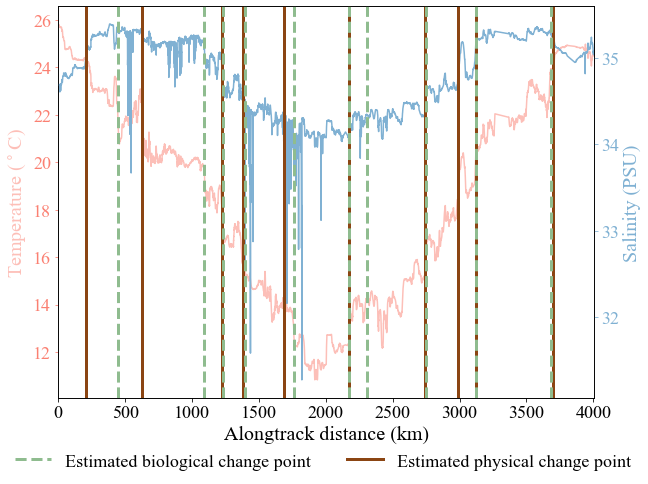

In [14]:
from utils import utils

dists = utils.compute_distances(np.array(phys_data[['latitude']]), np.array(phys_data[['longitude']]))
temp_salinity_plot(cps_bio, cps_phys)

From the above plot we can see that the physical change points do correspond to large changes in the temperature and/or salinity data. Moreover, the biological change points are also typically near large changes in the temperature and salinity data. 

Next we'll take a look at the distribution of particle labels over time and overlay the biological change points (recall that the algorithm didn't have access to the particle labels). From the plot below we can see that we do appear to detect changes in the distribution of the labeled particles.

In [15]:
from figures import figure_utils

def distribution_figure(cps_bio, unique_pop=None):
    cum_dists_cps = np.cumsum([0] + [dists[cps_bio[0]]]
                              + [dists[cps_bio[i+1]]-dists[cps_bio[i]] for i in range(len(cps_bio)-1)]
                              + [dists[-1]-dists[cps_bio[-1]]])

    # Generate the histograms for each time point
    times = np.array(pd.Series(bio_data['date']).astype('category').cat.codes.values + 1)
    hists, labels = figure_utils.get_pop_hists(bio_data['pop'].tolist(), times,
                                               unique_pop=['picoeuk', 'synecho',  'prochloro'], normalize=True)

    # Plot the histograms, overlay the change points, and add arrows on top of the plot
    colors = ['#3eddf2', '#e542f4', '#D0D697']
    labels = ['Picoeukaryotes', 'Synechococcus', 'Prochlorococcus']

    plt.clf()
    fig = plt.figure(figsize=(9.6, 7.2))
    ax = fig.add_subplot(111)
    plt.fill_between(dists[:-1], 0, np.sum(hists[:, 0:1], axis=1)[:-1], color=colors[0], label=labels[0])
    plt.fill_between(dists[:-1], np.sum(hists[:, 0:1], axis=1)[:-1], np.sum(hists[:, 0:2], axis=1)[:-1],
                     color=colors[1], label=labels[1])
    plt.fill_between(dists[:-1], np.sum(hists[:, 0:2], axis=1)[:-1], 1, color=colors[2], label=labels[2])
    for dist in cum_dists_cps:
        plt.axvline(x=dist, ls='-', c='black')

    # Edit the axis limits and labels, along with the legend
    plt.xlabel('Alongtrack distance (km)', fontsize=20)
    plt.ylabel('Fraction of observed population', fontsize=20)
    plt.xlim(0, dists[-1])
    plt.ylim(0, 1)
    ax.tick_params(axis='both', which='major', labelsize=14)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize=16)
    plt.gcf().subplots_adjust(bottom=0.15)

Computing histograms...
100.00 % done 		


<Figure size 432x288 with 0 Axes>

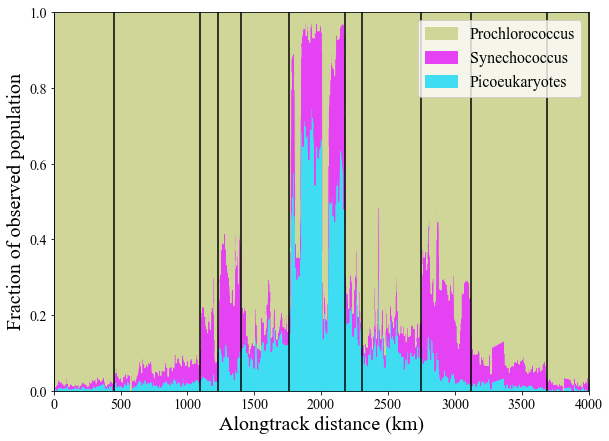

In [16]:
unique_pop = ['picoeuk', 'synecho', 'prochloro', 'unknown', 'beads']
distribution_figure(cps_bio, unique_pop=unique_pop)

Finally, we can plot where the change points are on top of the map of the cruise. There are several groups that are each close together, and this is in part because some change points were detected both on the way out and on the way back. The location of the ship on the way out is shown in gray, and the location on the way back is shown in blue. The change point locations detected on the way out are shown with black x's while the change points deteced on the way back are shown with red +'s.

<Figure size 432x288 with 0 Axes>

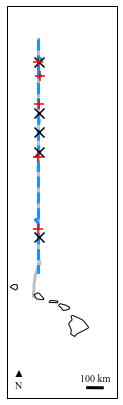

In [17]:
addl_lat = np.array(phys_data[['latitude']])[cps_bio]
addl_lon = np.array(phys_data[['longitude']])[cps_bio]
extent = [-160, -153, 15, 40]

figures.cruise_path_plot(phys_data[['latitude']], phys_data[['longitude']], extent=extent, 
                         addl_lat=addl_lat[:5], addl_lon=addl_lon[:5], addl_lat2=addl_lat[5:], 
                         addl_lon2=addl_lon[5:], colors='gray-blue', figure_size=(9.6, 7.2), save_path=None)

# 4. Change-Point Estimation with an Unknown Number of Change Points
Now we'll estimate the number of change points in the biological data. We manually produced annotations of the change points in the physical data for each cruise. To simulate the case where we don't have any annotations for the physical data on the cruise of interest, we'll make use of all of the annotations except those for KOK1606.

First we'll run a change-point estimation method on the physical data from each cruise for every number of change points between 0 and 150, where 150 is an upper bound on the number of change points in each cruise. We'll keep track of the objective value for every number of change points. Depending on your CPU, this may take several minutes.

In [18]:
import json
from sklearn.preprocessing import StandardScaler

cruises = ['DeepDOM', 'KM1712', 'KM1713', 'MGL1704', 'SCOPE_2', 'Thompson_1', 'Thompson_9', 'Thompson_12', 
           'Tokyo_1', 'Tokyo_2', 'Tokyo_3']
max_cp = 150
min_dist = 5

for i, cruise_i in enumerate(cruises):
    print('Estimating physical change points for', cruise_i, '- Cruise ', i+1, '/', len(cruises))
    # Load the physical data for cruise i
    phys_data_i = pd.read_parquet(os.path.join(data_dir, cruise_i + '_phys.parquet'))
    T_i = len(phys_data_i)
    # Obtain the number of annotated change points for this cruise
    n_cp_i = len(json.load(open(os.path.join(data_dir, cruise_i + '_annotated_phys_cps.json'), 'r')))
    # Extract the data used in the change-point estimation method and standardize it
    phys_features_i = np.asarray(phys_data_i[['temp', 'salinity']])
    phys_features_i = StandardScaler().fit_transform(phys_features_i)
    # Run the change-point estimation method and get the estimated change points and objective values for
    # every possible number of change points between 0 and max_cp (or a smaller maximum based on the specified
    # value of min_dist)
    cps_phys_i, objs_phys_i = cp_estimation.mkcpe(X=phys_features_i,
                                        n_cp=(0, min(max_cp, int((len(phys_features_i) - 1) / min_dist) - 1)),
                                        kernel_type='linear', min_dist=min_dist, return_obj=True)
    # Normalize the objective values by the length of the sequence
    for key in objs_phys_i:
        objs_phys_i[key] = objs_phys_i[key]/len(phys_features_i)
    # Store the results
    if i == 0:
        cp_results = pd.DataFrame({'cruise': cruise_i, 'T': T_i, 'n_cp': n_cp_i, 'objs': [objs_phys_i]})
    else:
        cp_results = cp_results.append({'cruise': cruise_i, 'T': T_i, 'n_cp': n_cp_i, 'objs': objs_phys_i}, 
                                       ignore_index=True)

Estimating physical change points for DeepDOM - Cruise  1 / 11
Estimating physical change points for KM1712 - Cruise  2 / 11
Estimating physical change points for KM1713 - Cruise  3 / 11
Estimating physical change points for MGL1704 - Cruise  4 / 11
Estimating physical change points for SCOPE_2 - Cruise  5 / 11
Estimating physical change points for Thompson_1 - Cruise  6 / 11
Estimating physical change points for Thompson_9 - Cruise  7 / 11
Estimating physical change points for Thompson_12 - Cruise  8 / 11
Estimating physical change points for Tokyo_1 - Cruise  9 / 11
Estimating physical change points for Tokyo_2 - Cruise  10 / 11
Estimating physical change points for Tokyo_3 - Cruise  11 / 11


Given these estimated change points, we tune the penalty parameter $\alpha$ from the penalized change-point method of Lebarbier (2005). Concretely, denote by $\mathcal{L}$ the change-point objective with the linear kernel and $m^{(i)\star}$ the number of annotated change points in auxiliary sequence $i$. We tune the penalty $\alpha$ of Lebarbier (2005) by minimizing the sum of the absolute difference between the number of annotated and estimated change points across all sequences:
\begin{align*}
&\min_{\alpha}\sum_{i=1}^S \left\vert \arg\min_{m}\left\{\min_{t_1,\dots, t_m} \mathcal{L}(t_1,\dots, t_m) + \text{pen}_i(\alpha, m) \right\}- m^{(i)\star}\right\vert
\end{align*}
where 
$$\text{pen}_i({\alpha}, m) = {\alpha}\frac{m+1}{T^{(i)}}\left\{2\log\left(\frac{T^{(i)}}{m+1}\right)+5\right\}\;$$
and $T^{(i)}$ is the length of sequence $i$.
We'll use a grid search to find the best $\alpha$.

In [19]:
alphas = np.arange(0, 1, 0.01) #  Grid of alphas to consider
errors_penalty = np.zeros(len(alphas)) #  Array for storing the sum of the errors obtained with each alpha
ncruises = len(cp_results)  # Number of cruises

for alpha_num, alpha in enumerate(alphas):
    for i in range(ncruises):
        objs = cp_results.iloc[i]['objs']
        T_i = cp_results.iloc[i]['T']
        # Convert the objective values to an array
        objs = np.array([objs[i] for i in range(0, len(objs))]).flatten()
        # Estimate the number of change points using the method of Lebarbier (2005) with the given value of 
        # alpha for this iteration
        d = np.arange(1, len(objs)+1)
        n_est_cps_i = np.argmin(objs + alpha*d/T_i*(2*np.log(T_i/d)+5))
        # Compute the error with this value of alpha for cruise i
        errors_penalty[alpha_num] += np.abs(n_est_cps_i - cp_results.iloc[i]['n_cp'])

# Find the alpha with the best error
best_alpha_idx = np.argmin(errors_penalty)
best_alpha = alphas[best_alpha_idx]

print('Best alpha:', best_alpha)

Best alpha: 0.13


Denoting the resultant minimizer by $\hat\alpha$, we then solve the penalized change-point problem
\begin{align*}
\min_{m=1,\dots, m_{\max}}\min_{t_1,\dots, t_m} \mathcal{L}(t_1,\dots, t_m) + \text{pen}({\hat\alpha}, m) 
\end{align*}
on the physical data from KOK1606 to estimate the number of change points in the biological time series from KOK1606.

In [20]:
# Load the data
cruise = 'SCOPE_16'
phys_data = pd.read_parquet(os.path.join(data_dir, cruise + '_phys.parquet'))
phys_features = np.asarray(phys_data[['salinity','temp']])
phys_features = (phys_features-np.mean(phys_features, axis=0))/np.std(phys_features, axis=0)
T = len(phys_features)

# Compute the objective value for every number of change points between 0 and max_cp (or a smaller maximum 
# based on the specified value of min_dist)
cps_phys, objs_phys = cp_estimation.mkcpe(X=phys_features,
                                        n_cp=(0, min(max_cp, int((len(phys_features) - 1) / min_dist) - 1)),
                                        kernel_type='linear', min_dist=min_dist, return_obj=True)
# Normalize the objective values by the length of the sequence
for key in objs_phys:
    objs_phys[key] = objs_phys[key]/T
# Convert the objective values to an array
objs_phys = np.array([objs_phys[i] for i in range(0, len(objs_phys))]).flatten()

# Estimate the number of change points
d = np.arange(1, len(objs_phys)+1)
n_est_cps = np.argmin(objs_phys + best_alpha*d/T*(2*np.log(T/d)+5))
cps_phys = cps_phys[n_est_cps]

print('Estimated number of change points:', n_est_cps)
print('Estimated physical change-points (in terms of time indices):', cps_phys.flatten())

Estimated number of change points: 65
Estimated physical change-points (in terms of time indices): [  40  134  263  413  760  824  849  950  955  967  972  978  983 1079
 1572 1701 1973 2125 2308 2515 2553 2566 2571 2612 2619 2624 2639 2644
 2835 2955 2979 2984 3013 3018 3036 3080 3105 3110 3139 3484 3571 3855
 3972 4223 4356 4385 4430 4504 4667 4759 4897 4959 5033 5096 5260 5277
 5322 5413 5560 5785 5886 6307 6349 6416 6630]


Finally, using the number of change points estimated for the physical data as the number of change points in the biological data, we estimate the locations of the change points in the biological data.

In [21]:
cps_bio = cp_estimation.mkcpe(X=bio_features, n_cp=int(n_est_cps), kernel_type='gaussian-euclidean', bw=None, 
                              min_dist=5)

print('Estimated biological change points (in terms of time indices):', cps_bio.flatten())

Bandwidth not specified. Using a rule of thumb.
Estimated biological change points (in terms of time indices): [  63  153  210  388  552  610  681  858 1073 1371 1559 1721 1798 1969
 2065 2091 2128 2288 2335 2437 2512 2572 2622 2775 2840 2873 2949 3041
 3086 3134 3296 3489 3574 3742 3860 3945 3972 4094 4211 4261 4305 4387
 4432 4486 4504 4544 4715 4756 4960 5036 5108 5130 5232 5264 5325 5417
 5485 5609 5897 6065 6126 6241 6314 6361 6600]


Now we can visualize the results.

<Figure size 432x288 with 0 Axes>

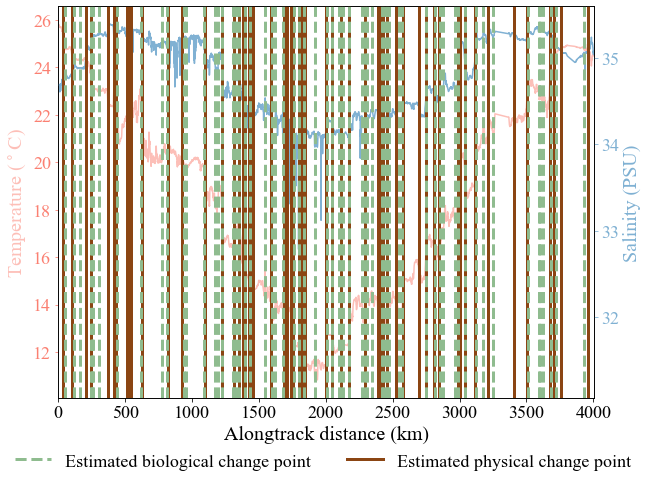

In [22]:
temp_salinity_plot(cps_bio, cps_phys)

Computing histograms...
100.00 % done 		


<Figure size 432x288 with 0 Axes>

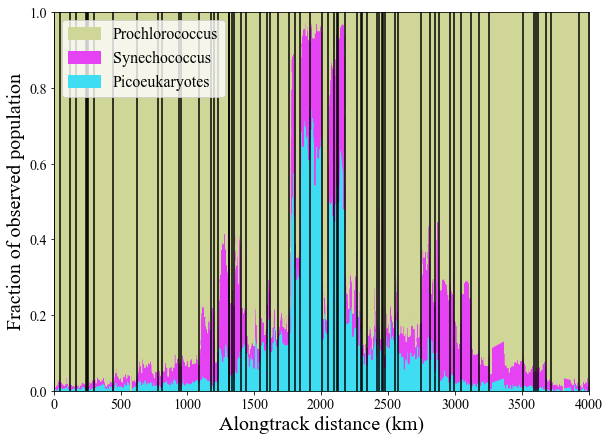

In [23]:
distribution_figure(cps_bio, unique_pop=unique_pop)

<Figure size 432x288 with 0 Axes>

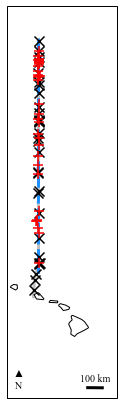

In [24]:
turnaround_point = np.argmax(np.array(phys_data[['latitude']]))
addl_lat = [np.array(phys_data[['latitude']])[cp_bio] for cp_bio in cps_bio if cp_bio <= turnaround_point]
addl_lon = [np.array(phys_data[['longitude']])[cp_bio] for cp_bio in cps_bio if cp_bio <= turnaround_point]
addl_lat2 = [np.array(phys_data[['latitude']])[cp_bio] for cp_bio in cps_bio if cp_bio > turnaround_point]
addl_lon2 = [np.array(phys_data[['longitude']])[cp_bio] for cp_bio in cps_bio if cp_bio > turnaround_point]

figures.cruise_path_plot(phys_data[['latitude']], phys_data[['longitude']], extent=extent, addl_lat=addl_lat,
                         addl_lon=addl_lon, addl_lat2=addl_lat2, addl_lon2=addl_lon2, 
                         colors='gray-blue', figure_size=(9.6, 7.2), save_path=None)

## References
- Z. Harchaoui and O. Cappé. Retrospective mutiple change-point estimation with kernels. In *IEEE Workshop on Statistical Signal Processing*, pages 768–772, 2007.
- E. Lebarbier. Detecting multiple change-points in the mean of Gaussian process by model selection.
*Signal Processing*, 85(4):717–736, 2005.
- A. Smola, A. Gretton, L. Song, and B. Schölkopf. A Hilbert Space Embedding for Distributions. In *Proceedings of the International Conference on Algorithmic Learning Theory*, pages 13-31, 2007.  
- C. K. Williams and M. Seeger. Using the Nyström method to speed up kernel machines. In *Advances
in Neural Information Processing Systems*, pages 661–667, 2000.
